
# Notebook Overview
This notebook focuses on building and training a sequence-to-sequence (Seq2Seq) model for English-to-Hindi translation. The core of the model is built using Recurrent Neural Networks (RNNs) with a specific type of gated recurrent unit (GRU) and an attention mechanism.

The process followed in the notebook can be summarized in these key steps:

Data Preparation: The notebook starts by loading an English-Hindi dataset from a CSV file. The data is then cleaned by removing punctuation and tokenized into lists of words. A vocabulary is built for both English and Hindi, and sentences are converted into numerical representations. Word embeddings are also created using the Word2Vec model, which are then used to initialize the embedding layers of the neural network.

Model Architecture: The notebook implements a standard encoder-decoder architecture. The encoder processes the input English sentence, and the decoder generates the output Hindi sentence. The crucial component here is the attention mechanism (specifically, the Luong Attention) which helps the decoder focus on relevant parts of the source sentence when generating each word of the target sentence.

Training: The Seq2Seq model is trained for a number of epochs. During training, it calculates the loss between the model's predictions and the actual target sentences. It uses an optimizer to update the model's weights and a learning rate scheduler to adjust the learning rate over time.

Evaluation: After training, the model's performance is evaluated using the BLEU (Bilingual Evaluation Understudy) score, a common metric for machine translation. The notebook also includes a translate function to test the model with new English sentences and observe its Hindi translations.

Experimentation: The notebook then explores two variations of the basic Seq2Seq model:

**A single GRU**

**Deep GRUs**: A model with multiple layers in the GRU for both the encoder and decoder.

**Bidirectional GRUs**: A model where the encoder processes the input sequence in both forward and backward directions to capture more context.

The validation loss curves show that the models are overfitting, as the training loss decreases significantly while the validation loss increases. The BLEU scores are also very low, indicating poor translation quality. **This is likely because the models were trained on a very small subset (20,000 pairs) of a larger dataset, which does not provide enough vocabulary and context for effective translation. To improve performance, we should train the model on the full dataset and then validate on the new data not from the datet that we are using and consider using more advanced architectures**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import re
from nltk.translate.bleu_score import sentence_bleu

In [3]:
import gensim
from gensim.models import Word2Vec

In [4]:
torch.manual_seed(42)

In [7]:
df=pd.read_csv('/kaggle/input/english-hindi-dataset/Dataset_English_Hindi.csv')
df.sample(3)

,English,Hindi
17802,The never feed and their alimentary canal is f...,वे कभी नहीं खाते और उनकी आहार नाल हवा से भर रह...
85443,"Biological pollutants include bacteria , virus...","जैविक प्रदूषक हैं जीवाणु , विषाणु , पौधे और जं..."
25127,"just before she returned to the United States,","उनके अमरीका लौटने के कुछ ही समय पहले,"


In [8]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
df.shape

(130476, 2)

In [10]:
df.isnull().sum()

English      2
Hindi      312
dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
df.isnull().sum()

English    0
Hindi      0
dtype: int64

In [13]:
df=df[:20000]

In [14]:
df.sample(10)

,English,Hindi
10983,Madhukalash [1937],मधुकलश (1937)
3112,Even defence production-the most sacred bastio...,यहां तक कि स्वदेशी वालं के लिए सबसे पवित्र क्ष...
1814,You don't have to chat with them.,तुम्हे उसने गप मारने की ज़रूरत नहीं है।
9935,-LRB- Paid rehearsals do require a work permit...,( पैसे दे कर किये जाने वाले पूर्व अभ्यास के लि...
8105,After some argument boat-driver left them acro...,कुछ आनाकानी करने के बाद केवट ने तीनों को गंगा ...
16510,. Men (giver) the odds :):):):):). Men(giver) ...,· पुरुष (Giver) को सहूलियत ☻☻☻☻ ☺ · पुरुष (Giv...
625,He deals in furniture.,वो फ़र्निचर का व्यापार करता है।
13575,It is also said that Indian People named him w...,किवदंती यह भी है कि भारत की जनता ने उनके सफल ए...
16099,today in europen states curry means the indian...,आज तो यूरोपियन देशों में करी इंडियन डिशेस का प...
4668,And that's nothing.,और ये तो कुछ भी नहीं |


In [15]:
import re
def clean_hindi_english(text):
    return re.sub(r'[-!()?,.\'\":\u0964]',' ',str(text))

In [16]:
df['English']=df['English'].apply(clean_hindi_english)
df['Hindi']=df['Hindi'].apply(clean_hindi_english)

### we are keeping a max word limitto 40 as the model was traing very slow so we try to limit it 

In [17]:
def tokenize(text):
    if isinstance(text, list):
        # If it's already tokenized, just return as-is
        return [t.lower().strip() for t in text]
    else:
        # If it's a string, tokenize normally
        return text.lower().strip().split()[:40]

In [18]:
df['English']=df['English'].apply(tokenize)
df['Hindi']=df['Hindi'].apply(tokenize)

In [19]:
df.sample(4)

,English,Hindi
2689,"[it, was, so, noisy, that, i, couldn, t, make,...","[इतना, शोर, था, कि, किसी, को, भी, मेरी, आवाज़,..."
19268,"[two, stories, made, a, deep, impression, on, ...","[दो, कथाओं, ने, उस, पर, गहरी, छाप, छोड़ी]"
13208,"[engine, the, most, worrying, aspect, of, the,...","[इंजन, यह, सबसे, चिंताजनक, पहलू, है]"
17808,"[he, is, the, form, of, the, ultimate, power]","[भाव, से, ऊपर, उठकर, महाभाव, या, प्रेम, के, आर..."


###  Create vocabulary mappings for both English and Hindi languages , This function maps each unique word to a numerical index

In [20]:
def build_vocab(sentences, min_freq=1):
    freq = {}
    for sent in sentences:
        for word in sent:
            freq[word] = freq.get(word, 0) + 1
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    for word, count in freq.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    return vocab    

###  This function converts a sentence of words into a list of numerical indices

In [78]:
def encode_sentence(sentence, vocab, max_len):
    tokens = [vocab.get(word, vocab['<unk>']) for word in sentence]
    tokens = [vocab['<sos>']] + tokens + [vocab['<eos>']]
    tokens += [vocab['<pad>']] * (max_len - len(tokens))
    return tokens[:max_len]

### Build Word2Vec models for both English and Hindi vocabularies.
### This gives us dense vector representations for each word.

In [22]:
def train_word2vec(sentences, embedding_dim=128):
    model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, sg=1)
    return model

### Create embedding matrices for the model's layers , These matrices are initialized with the Word2Vec vectors.

In [23]:
def build_embedding_matrix(vocab, w2v_model, dim):
    matrix = np.zeros((len(vocab), dim))
    for word, idx in vocab.items():
        if word in w2v_model.wv:
            matrix[idx] = w2v_model.wv[word]
        else:
            matrix[idx] = np.random.normal(scale=0.6, size=(dim,))
    return torch.tensor(matrix, dtype=torch.float32)

In [24]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, embedding):
        super().__init__()
        self.embedding = embedding
        self.gru = nn.GRU(emb_dim, hid_dim,batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

In [25]:
class BahdanauAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.W1 = nn.Linear(hid_dim, hid_dim)
        self.W2 = nn.Linear(hid_dim, hid_dim)
        self.V = nn.Linear(hid_dim, 1)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden[-1].unsqueeze(1)
        score = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(hidden)))
        attn_weights = torch.softmax(score, dim=1)
        context = attn_weights.transpose(1,2) @ encoder_outputs
        return context, attn_weights

In [26]:
class LuongAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.linear = nn.Linear(hid_dim, hid_dim)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden[-1].unsqueeze(1)                     # shape: (batch, 1, hid_dim)
        projected = self.linear(hidden)                      # shape: (batch, 1, hid_dim)
        energy = torch.bmm(projected, encoder_outputs.transpose(1, 2))  # (batch, 1, src_len)
        attn_weights = torch.softmax(energy, dim=-1)         # (batch, 1, src_len)
        context = torch.bmm(attn_weights, encoder_outputs)   # (batch, 1, hid_dim)
        return context, attn_weights


In [27]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, embedding, attention):
        super().__init__()
        self.embedding = embedding
        self.attention = attention
        self.gru = nn.GRU(hid_dim + emb_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)

    def forward(self, inputs, hidden, encoder_outputs):
        inputs = inputs.unsqueeze(1)
        embedded = self.embedding(inputs)
        context, _ = self.attention(hidden, encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(rnn_input, hidden)
        prediction = self.fc(torch.cat((output.squeeze(1), context.squeeze(1)), dim=1))
        return prediction, hidden

In [28]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        tgt_len = tgt.size(1)
        tgt_vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input_token = tgt[:, 0]

        for t in range(1, tgt_len):
            output, hidden = self.decoder(input_token, hidden, encoder_outputs)
            outputs[:, t] = output
            teacher_force = np.random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = tgt[:, t] if teacher_force else top1

        return outputs

In [29]:
class TranslationDataset(Dataset):
    def __init__(self, src, tgt):
        self.src = src
        self.tgt = tgt

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return torch.tensor(self.src[idx]), torch.tensor(self.tgt[idx])

In [30]:
def train_model(seq2seq, dataloader, optimizer, criterion, device):
    seq2seq.train()
    epoch_loss = 0

    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = seq2seq(src, tgt)
        output_dim = output.shape[-1]
        loss = criterion(output[:, 1:].reshape(-1, output_dim), tgt[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [31]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
def evaluate_bleu(pairs, seq2seq, src_vocab, tgt_vocab, device, max_len):
    smooth_fn = SmoothingFunction().method4
    scores = []

    for src_tokens, tgt_tokens in pairs:
        # Convert token lists to sentences for translation
        src_sentence = ' '.join(src_tokens)

        # Translate
        pred_sentence = translate(src_sentence, seq2seq, src_vocab, tgt_vocab, device)

        # Convert prediction string to tokens
        hypothesis = pred_sentence.strip().split()

        if len(hypothesis) == 0:
            scores.append(0.0)
        else:
            # tgt_tokens is already a tokenized reference
            bleu = sentence_bleu([tgt_tokens], hypothesis, weights=(0.5, 0.5), smoothing_function=smooth_fn)
            scores.append(bleu)

    return sum(scores) / len(scores) if scores else 0.0

In [87]:
def translate(sentence, seq2seq, src_vocab, tgt_vocab, device, buffer=3):
    seq2seq.eval()
    if isinstance(sentence, torch.Tensor):
        sentence = sentence.item() 
    tokens = tokenize(sentence)
    max_len = len(tokens) + buffer
    encoded = encode_sentence(tokens, src_vocab, max_len)
    src_tensor = torch.tensor(encoded).unsqueeze(0).to(device)
    with torch.no_grad():
        encoder_outputs, hidden = seq2seq.encoder(src_tensor)
        input_token = torch.tensor([tgt_vocab['<sos>']], device=device)
        outputs = []

        for _ in range(max_len):
            output, hidden = seq2seq.decoder(input_token, hidden, encoder_outputs)
            top1 = output.argmax(1)
            if top1.item() == tgt_vocab['<eos>']:
                break
            outputs.append(top1.item())
            input_token = top1

    inv_vocab = {v: k for k, v in tgt_vocab.items()}
    return ' '.join([inv_vocab.get(idx, '<unk>') for idx in outputs])

In [90]:
src_sentences = df['English'].tolist()
tgt_sentences = df['Hindi'].tolist()

In [91]:
len(tgt_sentences)

20000

In [92]:
len(src_sentences)

20000

In [93]:
pairs = list(zip(src_sentences, tgt_sentences))

In [94]:
pairs[:8]

[(['help'], ['बचाओ']),
 (['jump'], ['उछलो']),
 (['jump'], ['कूदो']),
 (['jump'], ['छलांग']),
 (['hello'], ['नमस्ते']),
 (['hello'], ['नमस्कार']),
 (['cheers'], ['वाह', 'वाह']),
 (['cheers'], ['चियर्स'])]

In [95]:
from sklearn.model_selection import train_test_split
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

In [116]:
train_pairs[:1]

[(['it',
   'would',
   'start',
   'to',
   'climb',
   'up',
   'the',
   'wall',
   'in',
   'jerky',
   'fashion'],
  ['यह',
   'दीवार',
   'पर',
   'झटको',
   'के',
   'साथ',
   'चढ़ना',
   'शुरू',
   'कर',
   'देती',
   'है'])]

In [96]:
val_pairs[:2]

[(['actually',
   'that',
   'photo',
   'was',
   'pasted',
   'in',
   'a',
   'police',
   'station'],
  ['वास्तव', 'में', 'यह', 'तस्वीर', 'एक', 'थाने', 'में', 'लगी', 'है']),
 (['hurry', 'and', 'you', 'will', 'catch', 'the', 'train'],
  ['जल्दी', 'करो', 'तो', 'ट्रेन', 'पकड़', 'सकते', 'हो'])]

In [97]:
src_train, tgt_train = zip(*train_pairs)
src_val, tgt_val = zip(*val_pairs)

In [114]:
src_val[:1]

(['actually',
  'that',
  'photo',
  'was',
  'pasted',
  'in',
  'a',
  'police',
  'station'],)

In [98]:
src_vocab = build_vocab(src_sentences)
tgt_vocab = build_vocab(tgt_sentences)

In [99]:
 len(src_vocab)  #unique wrds

23720

In [100]:
len(tgt_vocab) #unique words

29093

#### Find the maximum sentence length in the dataset.
### We'll use this to pad all sentences to a uniform length.

In [101]:
MAX_LEN = max(max(len(s) for s in src_sentences), max(len(s) for s in tgt_sentences)) + 2 

In [102]:
MAX_LEN

42

### Encode the training and validation sentences using the vocabularies

In [104]:
src_encoded_train = [encode_sentence(s, src_vocab, MAX_LEN) for s in src_train]
tgt_encoded_train = [encode_sentence(s, tgt_vocab, MAX_LEN) for s in tgt_train]
src_encoded_val = [encode_sentence(s, src_vocab, MAX_LEN) for s in src_val]
tgt_encoded_val = [encode_sentence(s, tgt_vocab, MAX_LEN) for s in tgt_val]

In [110]:
src_w2v = train_word2vec(src_train)  
tgt_w2v = train_word2vec(tgt_train)

In [117]:
src_matrix = build_embedding_matrix(src_vocab, src_w2v, 128)
tgt_matrix = build_embedding_matrix(tgt_vocab, tgt_w2v, 128)

In [118]:
src_matrix[:2]

tensor([[ 3.5651e-01, -2.6943e-01, -4.0204e-01, -1.0589e-02, -3.7213e-02,
         -2.6707e-01,  4.0137e-01,  3.5765e-01, -8.2419e-01, -5.0856e-02,
          9.2514e-02,  7.3275e-01,  6.0606e-01,  3.5309e-01,  2.3885e-01,
          3.6660e-03,  3.5257e-01, -1.2901e-01,  4.1647e-01,  4.4545e-01,
         -9.6242e-01, -5.0822e-02,  9.1969e-01, -6.7576e-01,  9.1870e-01,
         -3.5153e-01, -5.0091e-01, -1.5046e-01,  6.6573e-01, -2.1043e-01,
          1.2397e+00,  3.7399e-01,  1.7007e-01,  5.6487e-01, -3.7916e-01,
          2.6608e-01, -1.1869e-01,  5.9931e-01,  1.2269e+00, -5.3741e-01,
         -2.7669e-01,  4.3233e-01, -6.8665e-02, -3.7344e-01, -1.1197e+00,
          1.2188e+00, -1.0274e-01,  3.7825e-01,  1.3569e-01,  2.2107e-01,
         -7.3054e-01,  2.6898e-01,  4.0070e-02,  1.4046e-01,  2.1286e-01,
         -2.7074e-01, -1.1272e+00,  8.0930e-01,  7.4132e-02, -3.7664e-01,
         -2.3339e-01, -5.3559e-01,  2.2855e-01,  4.4033e-01, -3.0865e-02,
          4.8471e-01,  3.5366e-01,  1.

### Convert the matrices into PyTorch embedding layers


In [119]:
src_embedding = nn.Embedding.from_pretrained(src_matrix, freeze=False)
tgt_embedding = nn.Embedding.from_pretrained(tgt_matrix, freeze=False)

In [60]:
attention = LuongAttention(256) 
encoder1 = Encoder(len(src_vocab), 128, 256, src_embedding)
decoder1 = Decoder(len(tgt_vocab), 128, 256, tgt_embedding, attention)

In [61]:
dataset = TranslationDataset(src_encoded_train, tgt_encoded_train)
val_dataset=TranslationDataset(src_encoded_val,tgt_encoded_val)
train_data = DataLoader(dataset, batch_size=128, shuffle=True,pin_memory=True,num_workers=4)
val_data=DataLoader(val_dataset, batch_size=128, shuffle=False,pin_memory=True)

In [62]:
model = Seq2Seq(encoder1, decoder1, device)
model = model.to(device)

In [63]:
optimizer = optim.Adam(model.parameters(), lr=0.01)  # start from 0.01
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.63)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])

In [64]:
train_losses = []
val_losses = []

for epoch in range(50):
    model.train()
    epoch_train_loss = 0

    for src, tgt in train_data:
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model(src, tgt)

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_data)
    train_losses.append(train_loss)

    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for src, tgt in val_data:
            src, tgt = src.to(device), tgt.to(device)

            output = model(src, tgt)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            tgt = tgt[:, 1:].reshape(-1)

            loss = criterion(output, tgt)
            epoch_val_loss += loss.item()

    val_loss = epoch_val_loss / len(val_data)
    val_losses.append(val_loss)
    scheduler.step() 

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 01 | Train Loss: 7.3934 | Val Loss: 7.1014
Epoch 02 | Train Loss: 6.1408 | Val Loss: 6.9808
Epoch 03 | Train Loss: 5.1350 | Val Loss: 7.2399
Epoch 04 | Train Loss: 4.3707 | Val Loss: 7.5736
Epoch 05 | Train Loss: 4.0778 | Val Loss: 7.6795
Epoch 06 | Train Loss: 3.8646 | Val Loss: 7.6908
Epoch 07 | Train Loss: 3.6882 | Val Loss: 7.7353
Epoch 08 | Train Loss: 3.3871 | Val Loss: 7.8131
Epoch 09 | Train Loss: 3.2073 | Val Loss: 7.8354
Epoch 10 | Train Loss: 3.0275 | Val Loss: 7.9871
Epoch 11 | Train Loss: 2.6448 | Val Loss: 7.9032
Epoch 12 | Train Loss: 2.1628 | Val Loss: 8.0557
Epoch 13 | Train Loss: 1.8914 | Val Loss: 8.2273
Epoch 14 | Train Loss: 1.7424 | Val Loss: 8.3170
Epoch 15 | Train Loss: 1.6100 | Val Loss: 8.4709
Epoch 16 | Train Loss: 1.5161 | Val Loss: 8.5545
Epoch 17 | Train Loss: 1.4682 | Val Loss: 8.6392
Epoch 18 | Train Loss: 1.3933 | Val Loss: 8.7018
Epoch 19 | Train Loss: 1.3430 | Val Loss: 8.8575
Epoch 20 | Train Loss: 1.2817 | Val Loss: 8.9435
Epoch 21 | Train Los

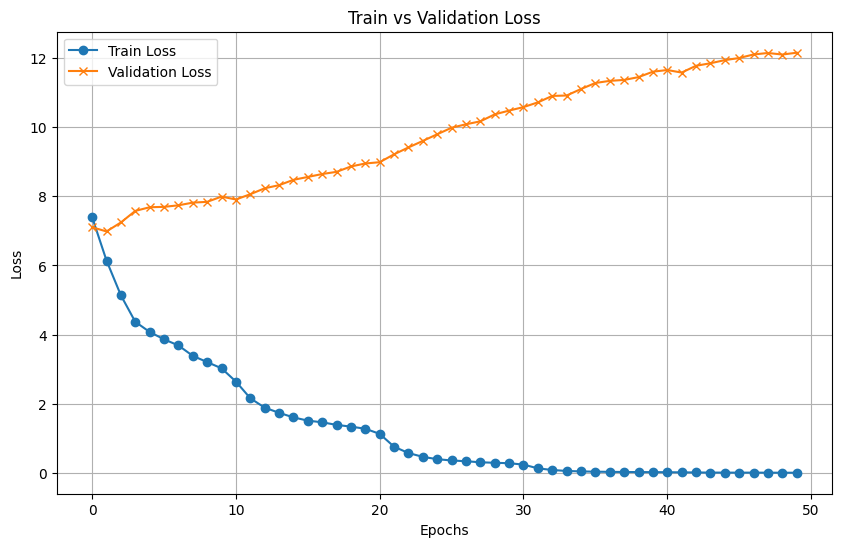

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [136]:
result=translate('it would start to climb up the wall in jerky fashion', model, src_vocab, tgt_vocab, device, buffer=3)
print(result)

आप केवल प्रयोग की तक रोक लगा गया है और केवल एक पत्र के


In [88]:
words=['it would start to climb up the wall in jerky fashion','hello','jump','hello how are you','how are you','i am fine','i hope you are well','What is the law','of psychological balance','A court being an outside authority does no','look up the phrase in your dictionary',
       'the best breeding tract comprises rohtak hissar jind nabha and patiala districts of the punjab','She is reading a book under the big tree.','We are planning a trip to the mountains this weekend',
      'He drinks a glass of milk every night before sleeping']
for words in words:
    result=translate(words, model, src_vocab, tgt_vocab, device, buffer=3)
    print(result)

में ही करने के
है और करने के
आप तो वे करने की बात है
आप आप के लिए है और
मैं सुरक्षा के लिए मैं है
आप है बात है मैं आपको बात है
है क्या करने के लिए वे यह
लेकिन बात करने में लेकिन उनका
की बात है कि वे और के लिए जरूरी है कि
की बात करने के लिए मैं उस बात से कि
की कुल और है और इस भूमिका से सर्वाधिक सम्मिलित है और महाभारत तट को और अंतरराष्ट्रीय प्रदेश
की और अभी तक इस बात की भूमिका रही है कि यह
की रूस से केवल स्वयं की करने के लिए इस ओर से कुछ
लेकिन आप में से भी धीरे होती है कि वे जैसे ही प्रदूषण


* actual
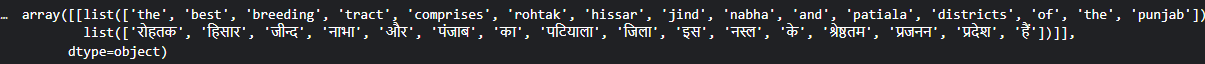

In [242]:
word

array([[list(['the', 'best', 'breeding', 'tract', 'comprises', 'rohtak', 'hissar', 'jind', 'nabha', 'and', 'patiala', 'districts', 'of', 'the', 'punjab']),
        list(['रोहतक', 'हिसार', 'जीन्द', 'नाभा', 'और', 'पंजाब', 'का', 'पटियाला', 'जिला', 'इस', 'नस्ल', 'के', 'श्रेष्ठतम', 'प्रजनन', 'प्रदेश', 'हैं'])]],
      dtype=object)

In [89]:
bleu = evaluate_bleu(val_pairs, model, src_vocab, tgt_vocab, device, max_len=MAX_LEN)
print(f"BLEU Score: {bleu:.4f}")

BLEU Score: 0.0463


In [120]:
torch.cuda.empty_cache()

## Deep GRUs

In [121]:
class DeepEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, embedding):
        super().__init__()
        self.embedding = embedding
        self.gru = nn.GRU(emb_dim, hid_dim,num_layers=3,batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

In [122]:
class DeepDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, embedding, attention):
        super().__init__()
        self.embedding = embedding
        self.attention = attention
        self.gru = nn.GRU(hid_dim + emb_dim, hid_dim,num_layers=3,batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)

    def forward(self, inputs, hidden, encoder_outputs):
        inputs = inputs.unsqueeze(1)
        embedded = self.embedding(inputs)
        context, _ = self.attention(hidden, encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(rnn_input, hidden)
        prediction = self.fc(torch.cat((output.squeeze(1), context.squeeze(1)), dim=1))
        return prediction, hidden

In [124]:
val_pairs[:1]

[(['actually',
   'that',
   'photo',
   'was',
   'pasted',
   'in',
   'a',
   'police',
   'station'],
  ['वास्तव', 'में', 'यह', 'तस्वीर', 'एक', 'थाने', 'में', 'लगी', 'है'])]

In [125]:
dataset = TranslationDataset(src_encoded_train, tgt_encoded_train)
val_dataset=TranslationDataset(src_encoded_val,tgt_encoded_val)
train_data = DataLoader(dataset, batch_size=128, shuffle=True,pin_memory=True,num_workers=4)
val_data=DataLoader(val_dataset, batch_size=128, shuffle=False,pin_memory=True)

In [126]:
attention = LuongAttention(256) 
encoder2 = DeepEncoder(len(src_vocab), 128, 256, src_embedding)
decoder2 = DeepDecoder(len(tgt_vocab), 128, 256, tgt_embedding, attention)

In [127]:
model_deep = Seq2Seq(encoder2, decoder2, device)
model_deep = model_deep.to(device)

In [138]:
optimizer = optim.Adam(model_deep.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.63)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])

In [141]:
train_losses_deep = []
val_losses_deep = []
model.train()
for epoch in range(50):
    model.train()
    epoch_train_loss = 0

    for src, tgt in train_data:
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model_deep(src, tgt)

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_data)
    train_losses_deep.append(train_loss)

    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for src, tgt in val_data:
            src, tgt = src.to(device), tgt.to(device)

            output = model_deep(src, tgt)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            tgt = tgt[:, 1:].reshape(-1)

            loss = criterion(output, tgt)
            epoch_val_loss += loss.item()

    val_loss = epoch_val_loss / len(val_data)
    val_losses_deep.append(val_loss)
    scheduler.step() 

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

RuntimeError: cudnn RNN backward can only be called in training mode

### it actually got appended to previous lossed so that is why the graph is liike this , so the actual graoh is 2nd one which you can easily be able to distinguish

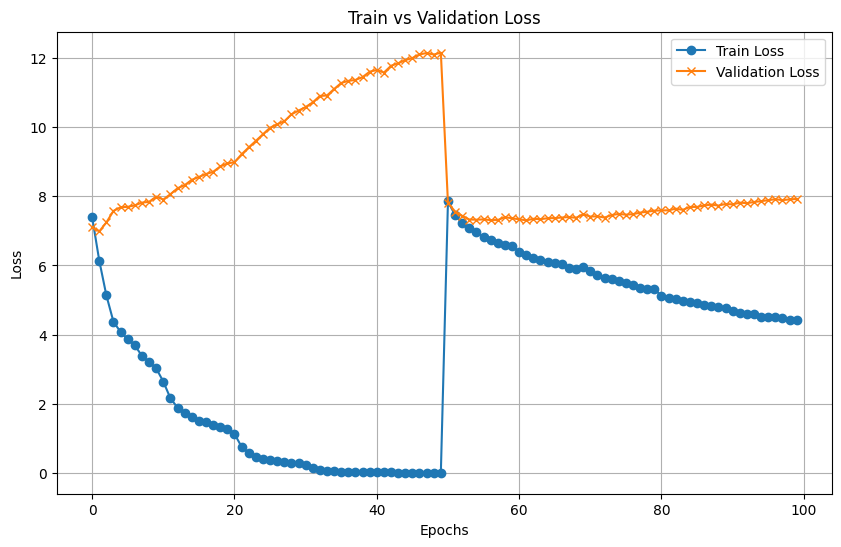

In [131]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [132]:
sample = src_val[0]
print("Original:", sample)
print("Tokens:", tokenize(sample))
print("Encoded:", encode_sentence(tokenize(sample), src_vocab, MAX_LEN))

Original: ['actually', 'that', 'photo', 'was', 'pasted', 'in', 'a', 'police', 'station']
Tokens: ['actually', 'that', 'photo', 'was', 'pasted', 'in', 'a', 'police', 'station']
Encoded: [1, 3187, 73, 9446, 89, 11207, 15, 106, 926, 645, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [134]:
words=['it would start to climb up the wall in jerky fashion','hello','jump','hello how are you','how are you','i am fine','i hope you are well','What is the law','of psychological balance','A court being an outside authority does no','look up the phrase in your dictionary',
       'the best breeding tract comprises rohtak hissar jind nabha and patiala districts of the punjab','She is reading a book under the big tree.','We are planning a trip to the mountains this weekend',
      'He drinks a glass of milk every night before sleeping']
for words in words:
    result=translate(words, model_deep, src_vocab, tgt_vocab, device, buffer=3)
    print(result)

यह में झटको में झटको के लिए चढ़ना नहीं
नमस्ते
कूदो
तुम बहुत नहीं
तू कैसी हो
मैं हिल हूँ
मैं तुमसे प्यार कर
यह भी देखें
शब्दकोश की
एक में में एक नहीं नहीं है
वह अपने में में अनपढ़ तेज़ है
रोहतक हिसार जीन्द नाभा नाभा के zसीमेंट के स्थित के के में में
वह फ़्लैट में बहुत मशहूर है
हम हम सब के के लिए हम हम के लिए
उसने अपने चुराने में लिए गिरफ़्तार किया


In [137]:
bleu = evaluate_bleu(val_pairs, model_deep, src_vocab, tgt_vocab, device, max_len=MAX_LEN)
print(f"BLEU Score: {bleu:.4f}")

BLEU Score: 0.0474


In [142]:
torch.cuda.empty_cache()

## Bidirectional GRUs

In [143]:
class BiEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, embedding):
        super().__init__()
        self.embedding = embedding
        self.gru = nn.GRU(emb_dim, hid_dim, num_layers=3, dropout=0.2,
                          bidirectional=True, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)             # [B, src_len, emb_dim]
        outputs, hidden = self.gru(embedded)       # outputs: [B, src_len, 2*hid_dim]
        return outputs, hidden 

### The output of this encoder has twice the hidden dimension (2 * hid_dim) because it's a concatenation of the forward and backward GRU outputs.
### It projects the decoder's hidden state to a size of 2 * enc_hid_dim to match the encoder's output when calculating energy and context.

In [144]:
class BiLuongAttention(nn.Module):
    def __init__(self, dec_hid_dim, enc_hid_dim):
        super().__init__()
        self.linear = nn.Linear(dec_hid_dim, 2 * enc_hid_dim)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden[-1].unsqueeze(1)                   # [B, 1, dec_hid_dim]
        projected = self.linear(hidden)                    # [B, 1, 2*enc_hid_dim]
        energy = torch.bmm(projected, encoder_outputs.transpose(1, 2))  # [B, 1, src_len]
        attn_weights = torch.softmax(energy, dim=-1)       # [B, 1, src_len]
        context = torch.bmm(attn_weights, encoder_outputs) # [B, 1, 2*enc_hid_dim]
        return context, attn_weights

### concatenated input of size emb_dim + 2 * enc_hid_dim. A key step in the BiSeq2Seq class is a helper function, _merge_bidir_hidden, which sums the forward and backward hidden states from the encoder to create a single hidden state for the decoder's initial state.

In [145]:
class BiDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, embedding, attention):
        super().__init__()
        self.embedding = embedding
        self.attention = attention
        self.gru = nn.GRU(emb_dim + 2 * enc_hid_dim, dec_hid_dim,
                          num_layers=3, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(dec_hid_dim + 2 * enc_hid_dim, output_dim)

    def forward(self, inputs, hidden, encoder_outputs):
        inputs = inputs.unsqueeze(1)                        # [B] -> [B, 1]
        embedded = self.embedding(inputs)                   # [B, 1, emb_dim]

        context, attn_weights = self.attention(hidden, encoder_outputs)  # [B, 1, 2*enc_hid_dim]

        rnn_input = torch.cat((embedded, context), dim=2)   # [B, 1, emb_dim + 2*enc_hid_dim]
        output, hidden = self.gru(rnn_input, hidden)        # output: [B, 1, dec_hid_dim]

        combined = torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)  # [B, dec_hid + 2*enc_hid]
        prediction = self.fc(combined)                      # [B, output_dim]

        return prediction, hidden

In [146]:
class BiSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        tgt_len = tgt.size(1)
        tgt_vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        # Encode
        encoder_outputs, encoder_hidden = self.encoder(src)

        # Merge hidden states
        decoder_hidden = self._merge_bidir_hidden(encoder_hidden)

        # First decoder input = <sos>
        input = tgt[:, 0]  # [B]

        for t in range(1, tgt_len):
            output, decoder_hidden = self.decoder(input, decoder_hidden, encoder_outputs)
            outputs[:, t] = output

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input = tgt[:, t] if teacher_force else top1

        return outputs

    def _merge_bidir_hidden(self, h):
        # Input: [num_layers*2, batch_size, hid_dim]
        num_layers = h.size(0) // 2
        h_fwd = h[0:num_layers]
        h_bwd = h[num_layers:]
        return h_fwd + h_bwd  # [num_layers, batch_size, hid_dim]

In [147]:
def Bitranslate(sentence, seq2seq, src_vocab, tgt_vocab, device, buffer=3):
    """
    Translates a sentence using a trained Seq2Seq model with a bidirectional encoder.
    """
    def merge_bidirectional_hidden(hidden):
        # hidden: [num_layers*2, batch, hid_dim]
        num_layers = hidden.size(0) // 2
        h_fwd = hidden[0:num_layers]
        h_bwd = hidden[num_layers:]
        return h_fwd + h_bwd  # [num_layers, batch, hid_dim]

    seq2seq.eval()
    tokens = tokenize(sentence.lower().strip())  # You can define tokenize = str.split
    max_src_len = len(tokens) + buffer

    # Encode input sentence
    src_indices = encode_sentence(tokens, src_vocab, max_src_len)  # assumes <pad> padding
    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = seq2seq.encoder(src_tensor)  # hidden: [6, 1, hid_dim]
        hidden = merge_bidirectional_hidden(hidden)            # [3, 1, hid_dim] for decoder

        input_token = torch.tensor([tgt_vocab['<sos>']], device=device)
        outputs = []

        for _ in range(max_src_len + buffer):
            output, hidden = seq2seq.decoder(input_token, hidden, encoder_outputs)
            top1 = output.argmax(1)
            if top1.item() == tgt_vocab['<eos>']:
                break
            outputs.append(top1.item())
            input_token = top1

    inv_vocab = {v: k for k, v in tgt_vocab.items()}
    return ' '.join([inv_vocab.get(idx, '<unk>') for idx in outputs])



In [148]:
dataset = TranslationDataset(src_encoded_train, tgt_encoded_train)
val_dataset=TranslationDataset(src_encoded_val,tgt_encoded_val)
train_data = DataLoader(dataset, batch_size=128, shuffle=True,pin_memory=True,num_workers=4)
val_data=DataLoader(val_dataset, batch_size=128, shuffle=False,pin_memory=True)

In [150]:
attention=BiLuongAttention(dec_hid_dim=256, enc_hid_dim=256)
encoder2 = BiEncoder(len(src_vocab), 128, 256, src_embedding)
decoder2= BiDecoder(len(tgt_vocab), 128, 256, 256, tgt_embedding, attention)

In [151]:
model_Bi = BiSeq2Seq(encoder2, decoder2, device)
model_Bi = model_Bi.to(device)

In [152]:
optimizer = optim.Adam(model_Bi.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.63)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])

In [153]:
train_losses_bi = []
val_losses_bi = []

for epoch in range(50):
    model.train()
    epoch_train_loss = 0

    for src, tgt in train_data:
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model_Bi(src, tgt)

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_data)
    train_losses_bi.append(train_loss)

    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for src, tgt in val_data:
            src, tgt = src.to(device), tgt.to(device)

            output = model_Bi(src, tgt)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            tgt = tgt[:, 1:].reshape(-1)

            loss = criterion(output, tgt)
            epoch_val_loss += loss.item()

    val_loss = epoch_val_loss / len(val_data)
    val_losses_bi.append(val_loss)
    scheduler.step() 

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 01 | Train Loss: 8.6930 | Val Loss: 8.1638
Epoch 02 | Train Loss: 7.6585 | Val Loss: 7.6366
Epoch 03 | Train Loss: 7.0896 | Val Loss: 7.3448
Epoch 04 | Train Loss: 6.6405 | Val Loss: 7.2601
Epoch 05 | Train Loss: 6.2563 | Val Loss: 7.1749
Epoch 06 | Train Loss: 5.9376 | Val Loss: 7.2222
Epoch 07 | Train Loss: 5.5964 | Val Loss: 7.3062
Epoch 08 | Train Loss: 5.2441 | Val Loss: 7.4345
Epoch 09 | Train Loss: 4.9780 | Val Loss: 7.5271
Epoch 10 | Train Loss: 4.7352 | Val Loss: 7.5911
Epoch 11 | Train Loss: 4.3627 | Val Loss: 7.5824
Epoch 12 | Train Loss: 4.1220 | Val Loss: 7.6315
Epoch 13 | Train Loss: 3.9377 | Val Loss: 7.6933
Epoch 14 | Train Loss: 3.8153 | Val Loss: 7.7397
Epoch 15 | Train Loss: 3.6916 | Val Loss: 7.8224
Epoch 16 | Train Loss: 3.5973 | Val Loss: 7.9970
Epoch 17 | Train Loss: 3.4735 | Val Loss: 7.9774
Epoch 18 | Train Loss: 3.3789 | Val Loss: 8.0593
Epoch 19 | Train Loss: 3.3158 | Val Loss: 8.1999
Epoch 20 | Train Loss: 3.2760 | Val Loss: 8.1882
Epoch 21 | Train Los

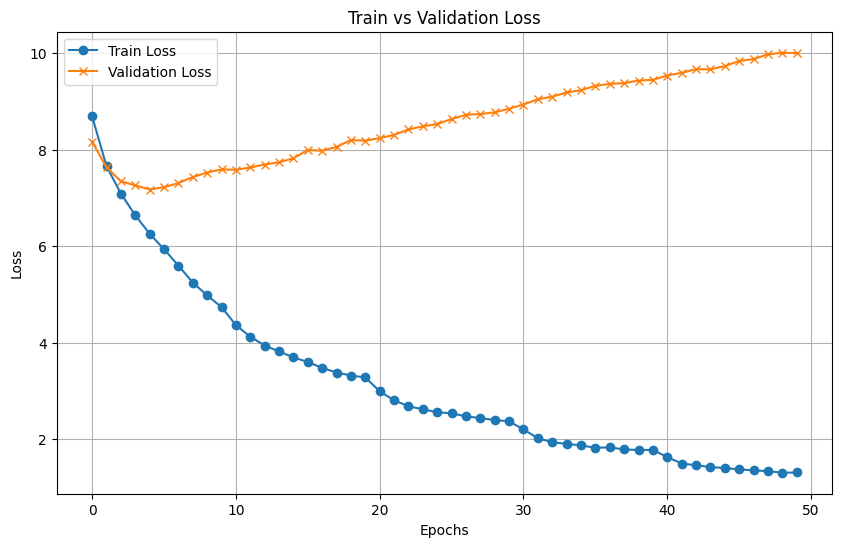

In [154]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses_bi, label="Train Loss", marker='o')
plt.plot(val_losses_bi, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [155]:
words=['hello','jump','how are you','i am fine','i hope you are well','What is the law','of psychological balance','A court being an outside authority does no','look up the phrase in your dictionary',
       'the best breeding tract comprises rohtak hissar jind nabha and patiala districts of the punjab','She is reading a book under the big tree.','We are planning a trip to the mountains this weekend',
      'He drinks a glass of milk every night before sleeping']
for words in words:
    result=Bitranslate(words, model_Bi, src_vocab, tgt_vocab, device, buffer=3)
    print(result)

इसने
विदेश और बीच चुने गये
तुम सब कैसे रहते हैं
मैं आमतौर से मैं बहुत हूँ
मैं यकीन है कि मैं किस किस से कर रहे हैं
कानून क्या है क्या
मनोवैज्ञानिक संतुलन की कहानी
एक सिद्धांत वाला कोई मतलब वाला या या या एक मतलब है या या
शब्दकोश में उस में में में में ढूँढो तो उन्होंने छोटा ढक
पंजाब के उत्तर शहर के भीतर में शहर का उत्तर किले से उत्तर किले से नीचे किले के श्रेष्ठतम और पूर्वी
वह एक आत्मा ही ही ही बड़े देश में गाँव में रहता है लेकिन उसमें
हम हम कुछ ही ही में एक एक कुछ दूसरे से कुछ दूसरे से कुछ कर
वह पहली बार आने वाली आशंका से आने से वापस आने से वह सुबह सुबह वापस


In [156]:
def bi_evaluate_bleu(pairs, seq2seq, src_vocab, tgt_vocab, device, max_len=40):

    smooth_fn = SmoothingFunction().method4
    scores = []

    for src_tokens, tgt_tokens in pairs:
        src_sentence = ' '.join(src_tokens)

        # Translate
        pred_sentence = Bitranslate(src_sentence, seq2seq, src_vocab, tgt_vocab, device)

        # Tokenize prediction
        hypothesis = pred_sentence.strip().split()

        if len(hypothesis) == 0:
            scores.append(0.0)
        else:
            bleu = sentence_bleu(
                [tgt_tokens],
                hypothesis,
                weights=(0.5, 0.5),  # BLEU-2
                smoothing_function=smooth_fn
            )
            scores.append(bleu)

    return sum(scores) / len(scores) if scores else 0.0

In [158]:
bleu = bi_evaluate_bleu(val_pairs, model_Bi, src_vocab, tgt_vocab, device)
print(f"BLEU Score: {bleu:.4f}")

BLEU Score: 0.0558
